In [1]:
import re
import pickle
import pandas as pd
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
from PIL import Image
from wordcloud import WordCloud
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from collections import Counter

## 데이터 로드

In [3]:
data = pd.read_csv("../data/hate_speech_large.csv")
data.columns = ["comments", "label"]
data.head()

,comments,label
0,정말 재밌다 연기도 좋고 디카프리오 짱,1
1,심쿵심쿵 미치네요이수혁땜에 잠 못자겠어요ㅠ자꾸 아른거림ㅠ,1
2,하지만 이니후빨러들은 이런거 관심 하나도 없음,0
3,@착한아이임당 A4 용지 덮고?,0
4,"진짜 평점 믿으면 안된 다는 걸 현실로 보여주는 영화입니다. 네티즌,전문가 하나같이...",1


In [4]:
print("댓글 개수 :",len(data)) # 댓글 개수 출력

댓글 개수 : 190000


## 데이터 정제

### 댓글의 중복 여부 확인

In [5]:
data['label'] = np.where(data['label'] == 0, 1, 0)

In [6]:
data['comments'].nunique(), data['label'].nunique()

(187142, 2)

In [7]:
data.drop_duplicates(subset=['comments'], inplace=True) # 중복 코멘트 제거
data.shape

(187143, 2)

In [8]:
print('총 샘플의 수 :',len(data))

총 샘플의 수 : 187143


#### 레이블 값의 분포

<AxesSubplot:>

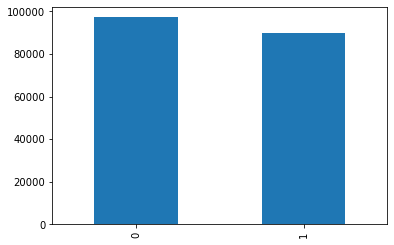

In [9]:
data['label'].value_counts().plot(kind = 'bar')

In [10]:
print(data.groupby('label').size().reset_index(name = 'count'))

   label  count
0      0  97223
1      1  89920


### Null 값 제거

In [11]:
print(data.isnull().values.any())

True


In [12]:
print(data.isnull().sum())

comments    1
label       0
dtype: int64


In [13]:
data.loc[data.comments.isnull()]

,comments,label
7807,NaN,0


In [14]:
data = data.dropna(how = 'any') # Null 값이 존재하는 행 제거
print(data.isnull().values.any()) # Null 값이 존재하는지 확인

False


In [15]:
print(len(data))

187142


### 한글, 공백 제외 전처리

In [16]:
data['comments'] = data['comments'].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]","")
data.head()

,comments,label
0,정말 재밌다 연기도 좋고 디카프리오 짱,0
1,심쿵심쿵 미치네요이수혁땜에 잠 못자겠어요ㅠ자꾸 아른거림ㅠ,0
2,하지만 이니후빨러들은 이런거 관심 하나도 없음,1
3,착한아이임당 용지 덮고,1
4,진짜 평점 믿으면 안된 다는 걸 현실로 보여주는 영화입니다 네티즌전문가 하나같이 영...,0


In [17]:
data['comments'] = data['comments'].str.strip()
data['comments'].replace('', np.nan, inplace=True)
print(data.isnull().sum())

comments    1021
label          0
dtype: int64


In [18]:
data = data.dropna(how = 'any')
print(len(data))

186121


### 워드클라우드
* 긍정/부정 댓글에서 빈도수가 가장 높은 명사들을 시각화

In [19]:
def get_nouns(data, label):
    okt = Okt()
    subset = data[data['label'] == label]
    text = subset['comments']
    
    morphs = []
    for sentence in text:
        morphs.append(okt.pos(sentence))

    nouns = []
    for morph in morphs:
        for word, tag in morph:
            if tag in ['Noun']:
                nouns.append(word)
    
    count = Counter(nouns)
    words = dict(count.most_common())
    
    return words

positive = get_nouns(data, 0)
negative = get_nouns(data, 1)

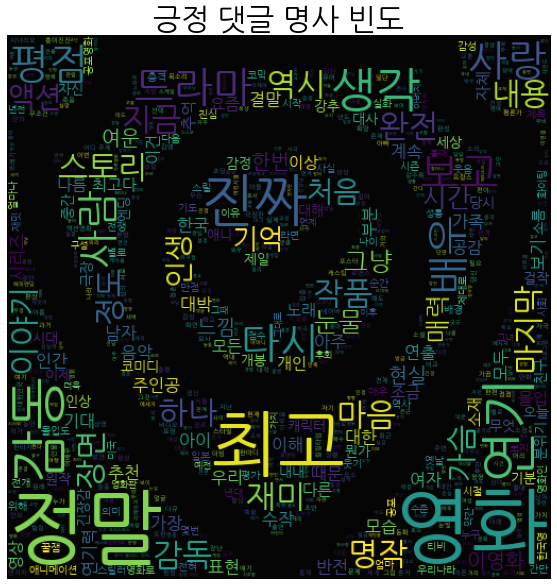

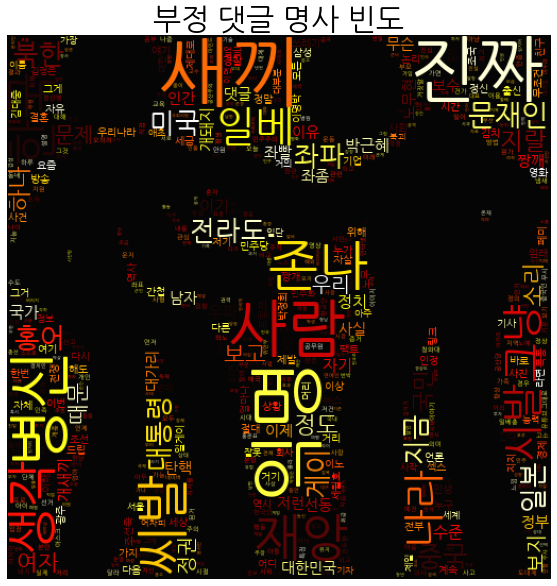

In [21]:
def generate_word_cloud(data, img, title, cmap):
    clean_mask = np.array(Image.open("../data/img/" + str(img) + ".png"))
    clean_mask = clean_mask[:,:,1]

    wc = WordCloud(font_path ='C:/Windows/Fonts/NanumGothic.ttf', 
                   background_color ="black",
                   max_words = 2000,
                   mask = clean_mask,
                   stopwords = stopwords)

    wc.generate(" ".join(data))
    plt.figure(figsize = (20, 10))
    plt.rc('font', family='NanumGothic')
    plt.axis("off")
    plt.title(title, fontsize = 30)
    plt.imshow(wc.recolor(colormap = cmap, random_state = 17), alpha = 0.98)
    plt.savefig(title + ".png")

stopwords = ['의','가','이','은','들','는','좀','잘','걍','과','도','를','으로','자','에','와','한','하다']
generate_word_cloud(positive, "safe-zone", "긍정 댓글 명사 빈도", "viridis")
generate_word_cloud(negative, "anger", "부정 댓글 명사 빈도", "hot")

### 형태소 분석기 별 데이터 분포

In [22]:
with open("../data/khaiii_train.pkl", "rb") as f:
    khaiii = pickle.load(f)
    
with open("../data/okt_train.pkl", "rb") as f:
    okt = pickle.load(f)

with open("../data/mecab_train.pkl", "rb") as f:
    mecab = pickle.load(f)
    
morphs = [khaiii, okt, mecab]  

In [23]:
def get_rare_cnt(data):
    threshold = 3
    rare_cnt, total_cnt = 0, len(tokenizer.word_index) 
    
    for key, value in tokenizer.word_counts.items():
        if(value < threshold):
            rare_cnt = rare_cnt + 1
        
    return total_cnt, rare_cnt

for i in range(len(morphs)):
    tokenizer = Tokenizer()
    tokenizer.fit_on_texts(morphs[i])
    
    total_cnt, rare_cnt = get_rare_cnt(tokenizer)
    vocab_size = total_cnt - rare_cnt + 2
    
    tokenizer = Tokenizer(vocab_size, oov_token = 'OOV') 
    tokenizer.fit_on_texts(morphs[i])
    
    morphs[i] = tokenizer.texts_to_sequences(morphs[i])
    drop_morph = [index for index, sentence in enumerate(morphs[i]) if len(sentence) < 1]
    
    morphs[i] = np.delete(morphs[i], drop_morph, axis=0)

C:\ProgramData\Miniconda3\lib\site-packages\numpy\core\_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


In [24]:
def below_threshold_len(max_len, nested_list):
    cnt = 0
    for s in nested_list:
        if(len(s) <= max_len):
            cnt = cnt + 1
    return max_len, cnt / len(nested_list) * 100

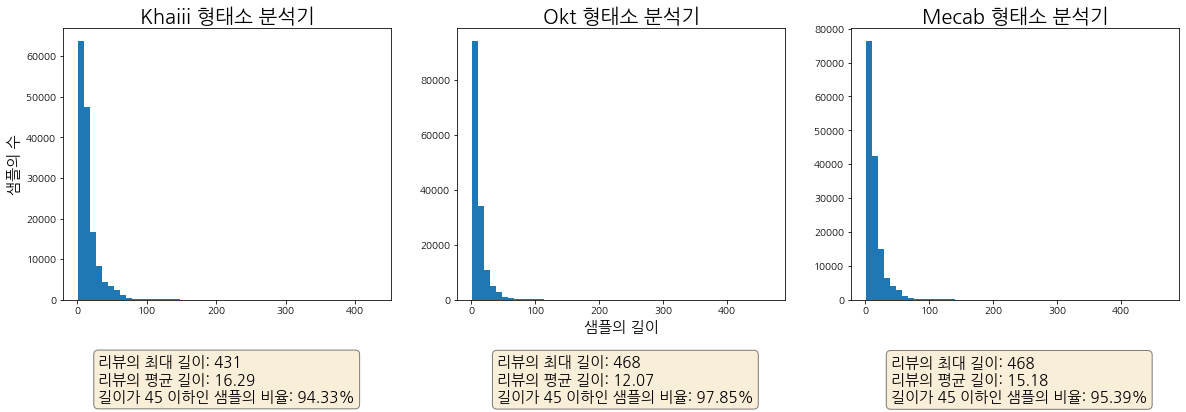

In [25]:
fig, axs = plt.subplots(1, 3, figsize=(20, 5))

axs = axs.ravel()
title = ["Khaiii", "Okt", "Mecab"]
pos = [(30, -13500), (40, -20000), (40, -16300)]

for i in range(len(axs)):
    axs[i].hist([len(s) for s in morphs[i]], bins=50)
    axs[i].set_title(title[i] + " 형태소 분석기", fontsize=20)
    
    if i == 0: 
        axs[i].set_ylabel("샘플의 수", fontsize=15)
    elif i == 1:
        axs[i].set_xlabel("샘플의 길이", fontsize=15)
    
    textstr = '\n'.join((
        r'리뷰의 최대 길이: %s' % (max(len(l) for l in morphs[i])),
        r'리뷰의 평균 길이: %.2f' % (sum(map(len, morphs[i]))/len(morphs[i])),
        r'길이가 %s 이하인 샘플의 비율: %.2f%%' % (below_threshold_len(45, morphs[i]))))
    
    props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)
    axs[i].text(pos[i][0], pos[i][1], textstr, verticalalignment='top', bbox=props, fontsize=15)
    
plt.rc('font', family='NanumGothic')
plt.show()